In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # Use seaborn's default style to make beautifull graphs

import pandas as pd

# Map exploration and add geo-coordinates

In [18]:
import folium
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

In [19]:
emdat_data = pd.read_excel("../data/public_emdat_incl_hist_2024-03-26.xlsx")
#emdat_data = pd.read_csv(f"updated_emdat_data.csv")

In [20]:
emdat_data.columns

Index(['DisNo.', 'Historic', 'Classification Key', 'Disaster Group',
       'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype',
       'External IDs', 'Event Name', 'ISO', 'Country', 'Subregion', 'Region',
       'Location', 'Origin', 'Associated Types', 'OFDA/BHA Response', 'Appeal',
       'Declaration', 'AID Contribution ('000 US$)', 'Magnitude',
       'Magnitude Scale', 'Latitude', 'Longitude', 'River Basin', 'Start Year',
       'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day',
       'Total Deaths', 'No. Injured', 'No. Affected', 'No. Homeless',
       'Total Affected', 'Reconstruction Costs ('000 US$)',
       'Reconstruction Costs, Adjusted ('000 US$)',
       'Insured Damage ('000 US$)', 'Insured Damage, Adjusted ('000 US$)',
       'Total Damage ('000 US$)', 'Total Damage, Adjusted ('000 US$)', 'CPI',
       'Admin Units', 'Entry Date', 'Last Update'],
      dtype='object')

Text(0.5, 1.0, 'Percentage of missing values in each column')

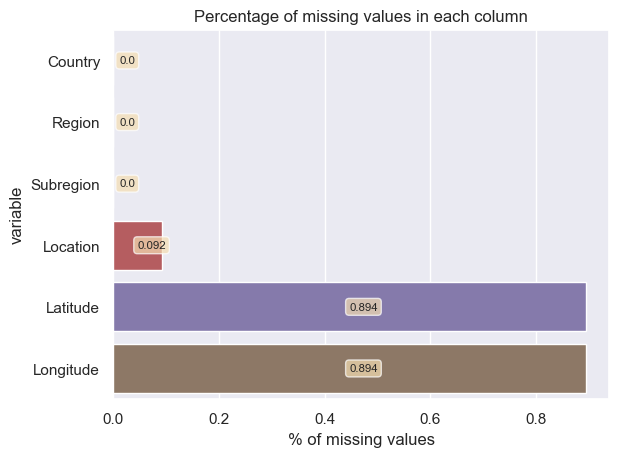

In [21]:
columns = ["Country","Region","Subregion","Location","Latitude","Longitude"]

fig, ax = plt.subplots()
sns.barplot(pd.DataFrame(emdat_data[columns].isna().mean()).reset_index().rename(columns={"index":"variable", 0:"% of missing values"}), y="variable", x="% of missing values", ax=ax, hue="variable", legend=False)
for i in ax.containers:
    ax.bar_label(
        i,
        fmt="{:.3}",
        label_type="center",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.7),
        padding=10,
        fontsize="x-small",
    )
# set title
ax.set_title("Percentage of missing values in each column")

- We almost don't have longitude and latitulde information, so start by using the disasters that have it.
- Then use locations columns, to obtain that info
- Then if location doesn't, use the country information with coordonates at the center
- Good idea to already preprocces all that data before, like add it to a our version of the data, to avoid the need to run when loading the page

In [22]:
def is_within_country(lat, lon, country, geolocator):
    try:
        # Reverse geocoding to get the country of the coordinates
        location = geolocator.reverse([lat, lon], exactly_one=True)
        address = location.raw['address']
        country_code = address.get('country_code', '').upper()
        return country_code == country
    except GeocoderTimedOut:
        print(f"Geocoder service timed out while checking coordinates within country.")
        return False
    
def geocode_location(location, geolocator, country):
    try:
        # Combine country and location for better geocoding accuracy
        query = f"{location}, {country}"
        print(f"Querying location: {query}")
        location_result = geolocator.geocode(query)

        if location_result:
            lat, lon = location_result.latitude, location_result.longitude
            print(f"Geocoded {query} to {lat}, {lon}")

            # Check if the coordinates are within the specified country
            if is_within_country(lat, lon, country, geolocator):
                return lat, lon
            else:
                print(f"Coordinates {lat}, {lon} are not in {country}")
                return None, None
        else:
            print(f"Could not geocode {query}")
            return None, None
    except Exception as e:
        print(f"Error geocoding {location}: {str(e)}")
        return None, None

def geocode_locations_and_update(data, info="Location"):    
    # Initialize a geocoder
    geolocator = Nominatim(user_agent="my_geocoder")

    # Apply geocoding to locations with missing latitude and longitude
    missing_coords = data[data['Latitude'].isna() | data['Longitude'].isna()]
    total_missing = len(missing_coords)
    print(f"Total missing locations to geocode: {total_missing}")

    # Reset progress counter
    progress_counter = 0

    # Save interval
    save_interval = 1000
    save_counter = 0


    for index, row in missing_coords.iterrows():
        # Geocode location using the 'Country' column for verification
        latitude, longitude = geocode_location(row[info], geolocator, row['ISO'])

        data.at[index, 'Latitude'] = latitude
        data.at[index, 'Longitude'] = longitude
        data.at[index, 'Coordinates Specific'] = latitude is not None and longitude is not None

        print(f"Updated {row[info]} with coordinates: {latitude}, {longitude}")
        # Update progress
        progress_counter += 1
        print(f"Progress: {progress_counter}/{total_missing} ({(progress_counter/total_missing)*100:.2f}%)")

        # Check if it's time to save the data
        if progress_counter % save_interval == 0:
            print("Saving progress...")
            # Concatenate with existing data and save to CSV
            data.to_csv(f'updated_emdat_data_{save_counter}.csv', index=False)

            # Increment save counter
            save_counter += 1

    # Save the final updated data to a new CSV file
    data.to_csv('updated_emdat_data_test.csv', index=False)


In [24]:
# Geocode the missing locations
geocode_locations_and_update(emdat_data, info= "Location")

Total missing locations to geocode: 23653
Querying location: Galveston (Texas), USA
Geocoded Galveston (Texas), USA to 29.3872254, -94.992736
Coordinates 29.3872254, -94.992736 are not in USA
Updated Galveston (Texas) with coordinates: None, None
Querying location: Hoboken, New York, Piers, USA
Could not geocode Hoboken, New York, Piers, USA
Updated Hoboken, New York, Piers with coordinates: None, None
Querying location: Saint James, JAM
Could not geocode Saint James, JAM
Updated Saint James with coordinates: None, None
Querying location: Porus, JAM
Could not geocode Porus, JAM
Updated Porus with coordinates: None, None
Querying location: nan, JPN
Geocoded nan, JPN to 34.7349692, 135.49454208413943
Coordinates 34.7349692, 135.49454208413943 are not in JPN
Updated nan with coordinates: None, None
Querying location: Bengal, IND
Geocoded Bengal, IND to 39.4735045, -85.9228997
Coordinates 39.4735045, -85.9228997 are not in IND
Updated Bengal with coordinates: None, None
Querying location: 

In [23]:
# Check the number of missing locations of the cvs file
data = pd.read_csv(f"updated_emdat_data_final.csv")

missing_coords = data[data['Latitude'].isna() | data['Longitude'].isna()]
total_missing = len(missing_coords)
print(f"Original total missing locations to geocode: {total_missing}")

FileNotFoundError: [Errno 2] No such file or directory: '4_emdat_data_all_coord.csv'

In [29]:
print("all",len(data))

# Drop technological disasters
data = data[data["Disaster Group"] != "Technological"]
# drop row with missing "total deaths"
data = data.dropna(subset=["Total Deaths"])

len(data)

all 17002


12100

### Normal Map (too crowded)

In [22]:
"""# Create a map centered around a specific location
m = folium.Map(location=[data['Latitude'].mean(), data['Longitude'].mean()], zoom_start=2)

# Add markers for each disaster location
for index, row in data.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']], popup=row['Location'],icon=folium.Icon(icon='info-sign', prefix='glyphicon')).add_to(m)

# Save the map to an HTML file
m.save('disaster_map.html')"""

### Clustered Map (look better and lees heavy)

In [23]:
"""from folium.plugins import MarkerCluster

# Create a map centered around a specific location
m = folium.Map(location=[data['Latitude'].mean(), data['Longitude'].mean()], zoom_start=2)

# Initialize a MarkerCluster object
marker_cluster = MarkerCluster().add_to(m)

# Add markers for each disaster location to the MarkerCluster
for index, row in data.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']], popup=row['Location'], icon=folium.Icon(icon='info-sign', prefix='glyphicon')).add_to(marker_cluster)

# Save the map to an HTML file
m.save('disaster_map_clustered.html')
"""

# Rename countries for json maps compatibility

In [12]:
emdat_data = pd.read_excel("../data/public_emdat_incl_hist_2024-03-26.xlsx")
sum(emdat_data["Country"] == "Soviet Union")

119

In [2]:
def get_data():
    data = pd.read_csv(f"../data/emdat_data.csv")

    rename = {
        "Antigua and Barbuda": "Antigua and Barb.",
        "Bolivia (Plurinational State of)": "Bolivia",
        "Bosnia and Herzegovina": "Bosnia and Herz.",
        "Brunei Darussalam": "Brunei",
        "Central African Republic": "Central African Rep.",
        "Cook Islands": "Cook Is.",
        "Democratic People's Republic of Korea": "North Korea",
        "Democratic Republic of the Congo": "Dem. Rep. Congo",
        "Dominican Republic": "Dominican Rep.",
        "Equatorial Guinea": "Eq. Guinea",
        "Iran (Islamic Republic of)": "Iran",
        "Lao People's Democratic Republic": "Laos",
        "Marshall Islands": "Marshall Is.",
        "Micronesia (Federated States of)": "Micronesia",
        "Republic of Korea": "South Korea",
        "Republic of Moldova": "Moldova",
        "Russian Federation": "Russia",
        "Saint Kitts and Nevis": "St. Kitts and Nevis",
        "Saint Vincent and the Grenadines": "St. Vin. and Gren.",
        "Sao Tome and Principe": "São Tomé and Principe",
        "Solomon Islands": "Solomon Is.",
        "South Sudan": "S. Sudan",
        "Swaziland": "eSwatini",
        "Syrian Arab Republic": "Syria",
        "The former Yugoslav Republic of Macedonia": "Macedonia",
        "United Republic of Tanzania": "Tanzania",
        "Venezuela (Bolivarian Republic of)": "Venezuela",
        "Viet Nam": "Vietnam",
        "Türkiye": "Turkey", # Add by myself
        "Netherlands (Kingdom of the)": "Netherlands",
        "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
        "Côte d’Ivoire": "Côte d'Ivoire",
        "State of Palestine": "Palestine",
        "British Virgin Islands": "British Virgin Is.",
        "Northern Mariana Islands": "N. Mariana Is.",
        "United States Virgin Islands": "U.S. Virgin Is.",
        "Saint Martin (French Part)": "St-Martin",
        "Sint Maarten (Dutch part)": "Sint Maarten",
        "Saint Barthélemy": "St-Barthélemy",
        "Germany Federal Republic": "Germany",
        "German Democratic Republic": "Germany",
        "China, Macao Special Administrative Region": "Macao",
        "China, Hong Kong Special Administrative Region": "Hong Kong",
        "Serbia Montenegro": "Serbia", # In 2003, the Federal Republic of Yugoslavia was reconstituted and re-named as a State Union of Serbia and Montenegro. This union effectively ended following Montenegro's formal declaration of independence on 3 June 2006 and Serbia's on 5 June 2006.
        "Eswatini": "eSwatini",
        "Saint Barthélemy": "St-Barthélemy",
        "Mayotte": "Mayotte",
        "French Guiana": "French Guiana",
        "Tokelau": "Tokelau",
        "Turks and Caicos Islands": "Turks and Caicos Is.",
        "Azores Islands": "Azores Is.",
        "Wallis and Futuna Islands": "Wallis and Futuna Is.",
        "Soviet Union": "Russia", # problem historic data
        "Yugoslavia": "Serbia", # In 2003, the Federal Republic of Yugoslavia was reconstituted and re-named as a State Union of Serbia and Montenegro. This union effectively ended following Montenegro's formal declaration of independence on 3 June 2006 and Serbia's on 5 June 2006.
        "Cayman Islands": "Cayman Is.",
        "Czechoslovakia": "Czech Republic",
        "French Polynesia": "French Polynesia",
        "Tuvalu": "Tuvalu",
        "Netherlands Antilles": "Netherlands",
        "Canary Islands": "Canary Is.",
        "North Macedonia": "Macedonia",
        "French Polynesia": "Fr. Polynesia",
        "Czech Republic": "Czechia",

    }

    # Apply renaming to the 'Country' column
    data['Country'] = data['Country'].map(rename).fillna(data['Country'])

    return data

In [3]:
data = get_data()
data.to_csv("emdat_data.csv")